In [1]:
import numpy as np
import torch
import os
import net
import utils
from PIL import Image
from tqdm import tqdm
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torchvision.utils import save_image, make_grid
from time import time
import pickle
import random
from pathlib import Path

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

In [3]:
BATCH_SIZE = 32
DS_FOLDER = "/home/ML_courses/03683533_2021/dataset"
LR = 1e-4
DEVICE_ID = 2
VAL_RANGE = 1000
TRAIN_RANGE = None
NUM_WORKERS = 16
NUM_EPOCHS = 20
SHUFFLE = False
RUN_NAME = '12layers_leakyr_l1'

# Network and optimizer

In [4]:
model = net.AutoEncoder()
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
device = f'cuda:{DEVICE_ID}' if torch.cuda.is_available() else 'cpu'
print(device)
model.to(device)

cuda:2


AutoEncoder(
  (enc1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (activation): LeakyReLU(negative_slope=0.01)
  (last_activation): Sigmoid()
  (enc1_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc2_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (enc3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc3_bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (enc4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc4_bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (enc5): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc5_bn): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_ru

# Data Loader & Dataset

In [5]:
transform = transforms.Compose([transforms.Resize(256),
                                transforms.ToTensor(),
                                ])

class UniDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform
        
    def __getitem__(self, index):
        image_path = self.image_paths[index]
        x = Image.open(image_path)
        if self.transform is not None:
            x = self.transform(x)
        return x
    
    def __len__(self):
        return len(self.image_paths)

In [6]:
val_files = [os.path.join(DS_FOLDER,i) for i in sorted(os.listdir(DS_FOLDER))[:VAL_RANGE]]
if TRAIN_RANGE != None:
    train_files = [os.path.join(DS_FOLDER,i) for i in 
                   sorted(os.listdir(DS_FOLDER))[VAL_RANGE+1:TRAIN_RANGE+1+VAL_RANGE]]
else:
    train_files = [os.path.join(DS_FOLDER,i) for i in sorted(os.listdir(DS_FOLDER))[VAL_RANGE+1:]]

In [7]:
val_ds = UniDataset(val_files, transform=transform)
train_ds = UniDataset(train_files, transform=transform)

In [8]:
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=True, shuffle=SHUFFLE)

# Train model

In [9]:
def save_imgs(true_imgs, val_imgs, dirname, epoch):
    path = os.path.join('results', RUN_NAME, epoch)
    os.makedirs(path, exist_ok=True)
    save_image(val_imgs, os.path.join(path, 'val_pred.png'))
    save_image(true_imgs, os.path.join(path, 'val_true.png'))

In [10]:
def calc_val_loss(val_dl, epoch, dirname):
    with torch.no_grad():
        val_loss = 0.0
        for images in val_dl:
            images = images.float().to(device)
            outputs = model(images)
            images.require_grad = False
            loss = criterion(outputs, images)
            val_loss += loss.item()
    images = images.cpu()
    outputs = outputs.view(outputs.size(0), 3, 256, 256).cpu().data
    save_imgs(images, outputs, dirname, epoch)
    return val_loss/len(val_dl), make_grid(images), make_grid(outputs)

In [11]:
%%time

train_losses = {}
val_losses = {}
for epoch in range(1, NUM_EPOCHS+1):
    t = time()
    train_loss = 0.0
    for images in tqdm(train_dl):
        images = images.float()
        images = images.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    val_loss, val_true_grid, val_pred_grid = calc_val_loss(val_dl, str(epoch), RUN_NAME)
    train_loss = train_loss/len(train_dl)
    train_losses[epoch] = train_loss
    val_losses[epoch] = val_loss
    print('Epoch: {} \tTraining Loss: {:.6f} \tVal Loss: {:.6f}\t \
    in time {:2f}m'.format(epoch, train_loss, val_loss, (time()-t)/60))


100%|███████████████████████████████████████| 1219/1219 [04:01<00:00,  5.05it/s]


Epoch: 1 	Training Loss: 0.128377 	Val Loss: 0.095833	     in time 4.078939m


100%|███████████████████████████████████████| 1219/1219 [04:02<00:00,  5.02it/s]


Epoch: 2 	Training Loss: 0.086108 	Val Loss: 0.077699	     in time 4.107391m


100%|███████████████████████████████████████| 1219/1219 [04:03<00:00,  5.01it/s]


Epoch: 3 	Training Loss: 0.072785 	Val Loss: 0.068016	     in time 4.112883m


100%|███████████████████████████████████████| 1219/1219 [04:03<00:00,  5.01it/s]


Epoch: 4 	Training Loss: 0.065095 	Val Loss: 0.062090	     in time 4.117818m


100%|███████████████████████████████████████| 1219/1219 [04:03<00:00,  5.01it/s]


Epoch: 5 	Training Loss: 0.060458 	Val Loss: 0.058723	     in time 4.118008m


100%|███████████████████████████████████████| 1219/1219 [04:03<00:00,  5.00it/s]


Epoch: 6 	Training Loss: 0.057740 	Val Loss: 0.056799	     in time 4.120077m


100%|███████████████████████████████████████| 1219/1219 [04:03<00:00,  5.01it/s]


Epoch: 7 	Training Loss: 0.056058 	Val Loss: 0.055549	     in time 4.118750m


100%|███████████████████████████████████████| 1219/1219 [04:03<00:00,  5.00it/s]


Epoch: 8 	Training Loss: 0.054946 	Val Loss: 0.054586	     in time 4.120013m


100%|███████████████████████████████████████| 1219/1219 [04:03<00:00,  5.01it/s]


Epoch: 9 	Training Loss: 0.054062 	Val Loss: 0.053781	     in time 4.117404m


100%|███████████████████████████████████████| 1219/1219 [04:03<00:00,  5.01it/s]


Epoch: 10 	Training Loss: 0.053377 	Val Loss: 0.053158	     in time 4.117947m


100%|███████████████████████████████████████| 1219/1219 [04:03<00:00,  5.00it/s]


Epoch: 11 	Training Loss: 0.052801 	Val Loss: 0.052593	     in time 4.120285m


100%|███████████████████████████████████████| 1219/1219 [04:03<00:00,  5.00it/s]


Epoch: 12 	Training Loss: 0.052263 	Val Loss: 0.052082	     in time 4.121838m


100%|███████████████████████████████████████| 1219/1219 [04:03<00:00,  5.01it/s]


Epoch: 13 	Training Loss: 0.051700 	Val Loss: 0.051533	     in time 4.119578m


100%|███████████████████████████████████████| 1219/1219 [04:03<00:00,  5.01it/s]


Epoch: 14 	Training Loss: 0.051105 	Val Loss: 0.050874	     in time 4.119071m


100%|███████████████████████████████████████| 1219/1219 [04:03<00:00,  5.00it/s]


Epoch: 15 	Training Loss: 0.050488 	Val Loss: 0.050264	     in time 4.121361m


100%|███████████████████████████████████████| 1219/1219 [04:03<00:00,  5.00it/s]


Epoch: 16 	Training Loss: 0.049937 	Val Loss: 0.049743	     in time 4.121909m


100%|███████████████████████████████████████| 1219/1219 [04:03<00:00,  5.00it/s]


Epoch: 17 	Training Loss: 0.049429 	Val Loss: 0.049248	     in time 4.121506m


100%|███████████████████████████████████████| 1219/1219 [04:03<00:00,  5.00it/s]


Epoch: 18 	Training Loss: 0.048969 	Val Loss: 0.048764	     in time 4.120033m


100%|███████████████████████████████████████| 1219/1219 [04:03<00:00,  5.01it/s]


Epoch: 19 	Training Loss: 0.048549 	Val Loss: 0.048323	     in time 4.119224m


100%|███████████████████████████████████████| 1219/1219 [04:03<00:00,  5.00it/s]


Epoch: 20 	Training Loss: 0.048144 	Val Loss: 0.047897	     in time 4.121182m
CPU times: user 1h 5min 40s, sys: 19min 54s, total: 1h 25min 35s
Wall time: 1h 22min 20s


# Results

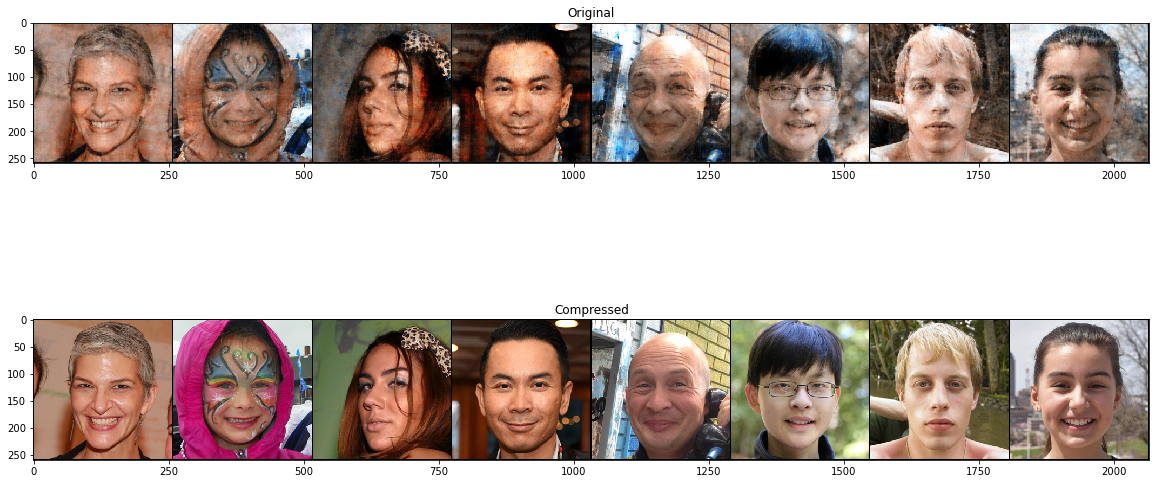

In [12]:
utils.show(val_true_grid, val_pred_grid)

In [13]:
path = Path("results") / RUN_NAME

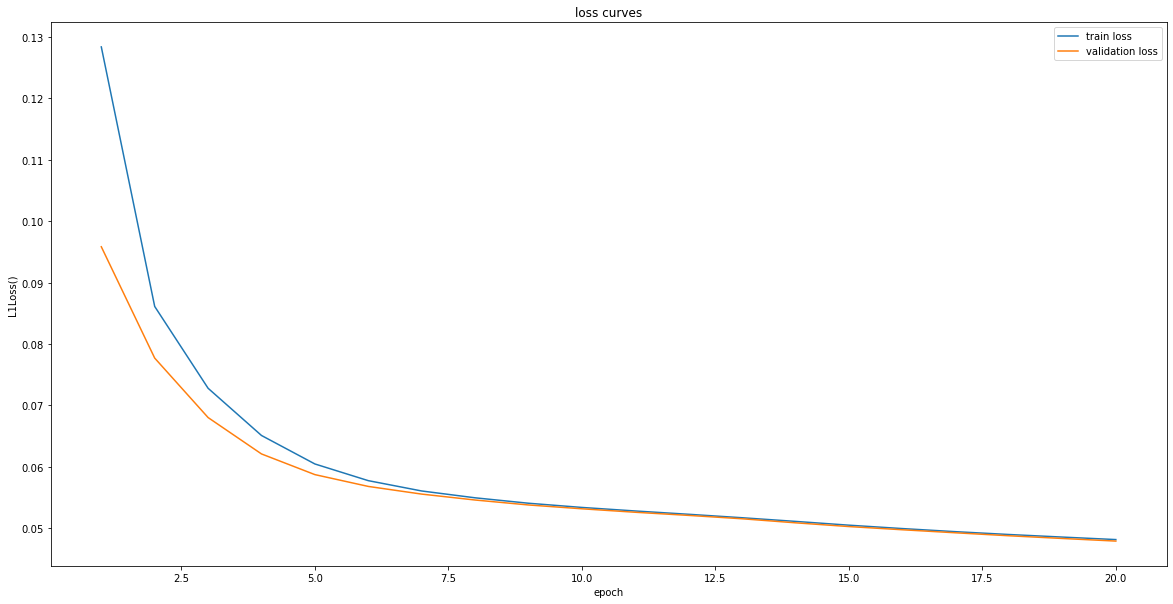

In [14]:
utils.plot_loss(criterion, train_losses, val_losses, path)

In [15]:
utils.write_losses(path, train_losses, val_losses)

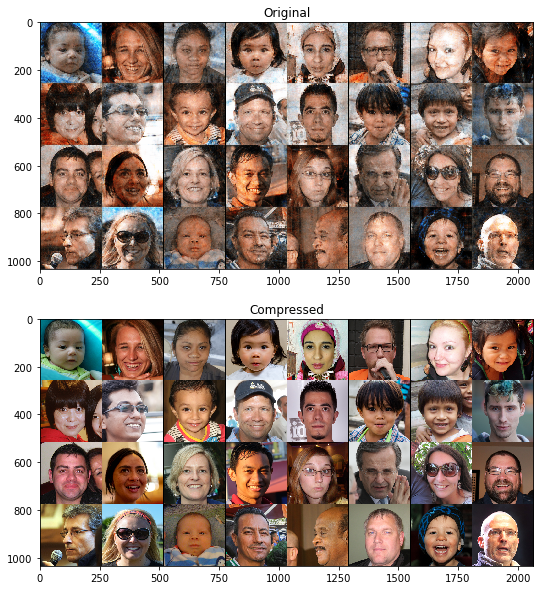

In [16]:
images = list(val_dl)[0]
outputs = model(images.to(device)).cpu()
utils.show(make_grid(images), make_grid(outputs), save=True, path=path)